# Customer Segmentation on Non-Store Online Retail Using RFM Analysis

### DataSets

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.
Source : https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci?select=online_retail_II.csv

### Goal

The goal of this project Is to understand customer segments and behavior using RFM (Recency, Frequency, Monetary) and K-means clustering methods using online retail dataset. The result of this analysis will be used to devise appropriate business approaches and strategies to increase revenue and transactions in the future.


# 1. Load Package and Configuration Settings.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import warnings
warnings.filterwarnings('ignore')

import datetime as dt
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 2. Load Datasets

In [2]:
df = pd.read_csv ('E:\DiBimbing\Talent Showcase\online_retail_II.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


Attribute Information:

*   InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
*   StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
*   Description: Product (item) name. Nominal.
*   Quantity: The quantities of each product (item) per transaction. Numeric.
*   InvoiceDate: Invoice date and time. Numeric. The day and time when a transaction was generated.
*   UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
*   CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
*   Country: Country name. Nominal. The name of the country where a customer resides.


In [4]:
# Checking Missing value and duplicated values

print('Missing Values')
print('-' * 50)
print(df.isnull().sum())
print()
print('Duplicated Rows')
print('-' * 50)
print(df.duplicated().sum())

Missing Values
--------------------------------------------------
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

Duplicated Rows
--------------------------------------------------
34335


In [5]:
print(f'Persentase missing value pada dataset : {round(len(df[df.isnull().any(axis=1)])/len(df)*100, 2)}%')

Persentase missing value pada dataset : 22.77%


**Insight**

1. Need to handle the duplicated rows
2. The Dataset have 22.77% of missing values, in the `Description` and `Customer ID` columns, and we will drop it for future analysis
3. We need to convert `InvoiceDate` column into datetime data type

In [6]:
# Convert InvoiceDate into datetime data type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
numerical = []
categorical = []
date = []
for i in df.columns:
    if (df[i].dtypes == 'float64') or (df[i].dtypes == 'int64'):
        numerical.append(i)
    elif (df[i].dtypes == 'object'):
        categorical.append(i)
    else:
        date.append(i)
print(f' numerical data : {numerical}')
print(f' categorical data : {categorical}')
print(f' date form data : {date}')

 numerical data : ['Quantity', 'Price', 'Customer ID']
 categorical data : ['Invoice', 'StockCode', 'Description', 'Country']
 date form data : ['InvoiceDate']


In [8]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0,9.938898,172.705794,-80995.00,1.00,3.0,10.00,80995.0
Price,1067371.0,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0
Customer ID,824364.0,15324.638504,1697.464450,12346.00,13975.00,15255.0,16797.00,18287.0


**Insight**
1. there are negative values in columns Quantity and Price.
2. There are 80.995 transaction are negative quantity, we will investigate it later if they have relate to canceled order
3. The negative value will be removed in case our focus on purchasing behavior from our customer
4. the maximum values that much higher than the mean and standard deviation indicate that the small item might be bought in the large Quantity

In [9]:
df[categorical].describe().T

,count,unique,top,freq
Invoice,1067371,53628,537434,1350
StockCode,1067371,5305,85123A,5829
Description,1062989,5698,WHITE HANGING HEART T-LIGHT HOLDER,5918
Country,1067371,43,United Kingdom,981330


**Insight**

1. White Hanging heart become the most transaction product frequencies.
2. United Kingdom become the country with the most transactions.

In [10]:
df[date].describe().T

,count,mean,min,25%,50%,75%,max
InvoiceDate,1067371,2011-01-02 21:13:55.394028544,2009-12-01 07:45:00,2010-07-09 09:46:00,2010-12-07 15:28:00,2011-07-22 10:23:00,2011-12-09 12:50:00


# 3. Data Preprocessing

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


## 3.1 Missing Data Handling

In [12]:
# check the missing value
counts = df.isna().sum().sort_values(ascending=False)

# percentage missing value
percents = round(df.isna().mean() * 100, 2).sort_values(ascending=False)

null = pd.concat([counts, percents], axis=1, keys=["null_counts", "Percentage"])
null

,null_counts,Percentage
Customer ID,243007,22.77
Description,4382,0.41
Invoice,0,0.00
StockCode,0,0.00
Quantity,0,0.00
InvoiceDate,0,0.00
Price,0,0.00
Country,0,0.00


1. There 22.77% data missing in Customer ID and 0.41% missing value from Description column
2. We will execute the missing value for the future analysis and build a new dataframe

In [13]:
df_new = df.dropna()
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824364 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      824364 non-null  object        
 1   StockCode    824364 non-null  object        
 2   Description  824364 non-null  object        
 3   Quantity     824364 non-null  int64         
 4   InvoiceDate  824364 non-null  datetime64[ns]
 5   Price        824364 non-null  float64       
 6   Customer ID  824364 non-null  float64       
 7   Country      824364 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 56.6+ MB


In [14]:
df_new['Customer ID'] = df_new['Customer ID'].astype(int)
df_new.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


## 3.2 Duplicated Data Handling

In [15]:
df_new.duplicated().sum()

26479

There are 26.479 duplicated transaction that need to be drop from dataset

In [16]:
df_new.drop_duplicates(inplace= True)

## 3.3 Canceled Order Analysis

In [17]:
df_new.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,797885.000000,797885,797885.000000,797885.000000
mean,12.602980,2011-01-02 13:17:34.141160704,3.702732,15313.062777
min,-80995.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,2.000000,2010-07-02 09:47:00,1.250000,13964.000000
50%,5.000000,2010-12-02 12:33:00,1.950000,15228.000000
75%,12.000000,2011-07-31 15:50:00,3.750000,16788.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,191.670371,NaN,71.392549,1696.466663


1. After droped missing value the minimum value from the Price become 0.
2. We need to investigate the negative value of quantity.

In [18]:
np.sum(df_new['Quantity'] < 0)

18390

In [375]:
canceled_order = df_new[df_new['Invoice'].str.contains('C', na = False)]
canceled_order.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia


In [376]:
(canceled_order['Invoice']).count()

18390

the number between negative quantity and canceled order invoice are match, so we will drop the negative value from quantity for future analysis

In [377]:
df_new = df_new[df_new['Quantity'] > 0]
df_new.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [378]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 779495 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779495 non-null  object        
 1   StockCode    779495 non-null  object        
 2   Description  779495 non-null  object        
 3   Quantity     779495 non-null  int64         
 4   InvoiceDate  779495 non-null  datetime64[ns]
 5   Price        779495 non-null  float64       
 6   Customer ID  779495 non-null  int32         
 7   Country      779495 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 50.6+ MB


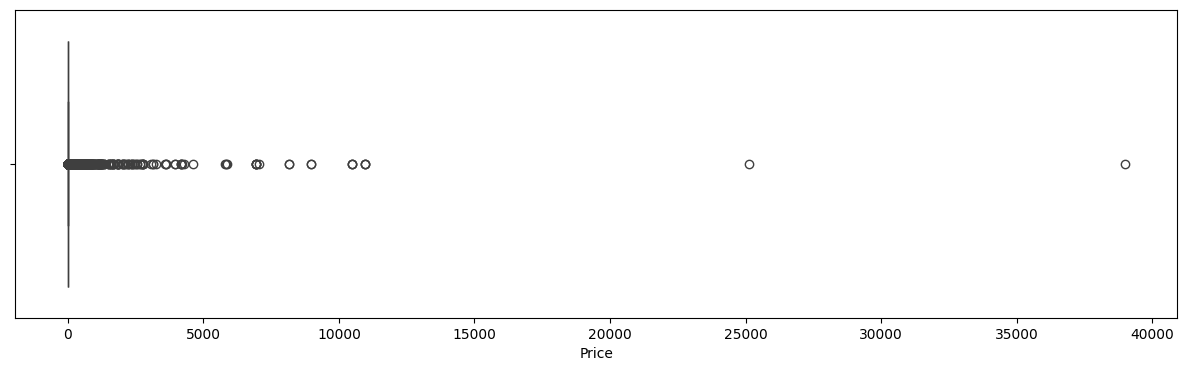

In [24]:
plt.subplots(figsize=(15, 4))
sns.boxplot(df_new.Price, orient= 'h')
plt.show()

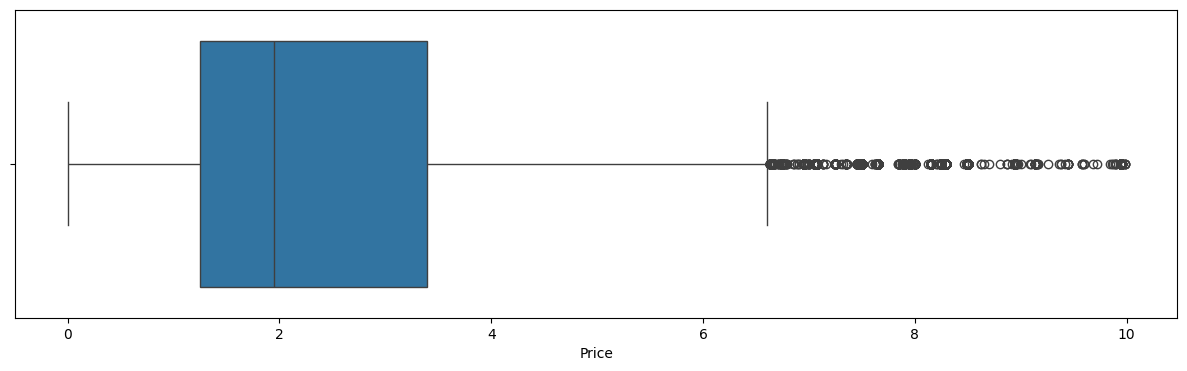

In [25]:
plt.subplots(figsize=(15, 4))
sns.boxplot(df_new[df_new['Price'] < 10].Price, orient= 'h')
plt.show()

As we can see the majority of our products price per unit lower than 7.

# 4. Exploratory Data Analysis

In [379]:
# We will add new column 'Total_Price'
df_new["TotalPrice"] = df_new["Quantity"] * df_new["Price"]

In [380]:
df_new.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


## How Many order Per Year

<Axes: xlabel='Invoice_year_month', ylabel='TotalPrice'>

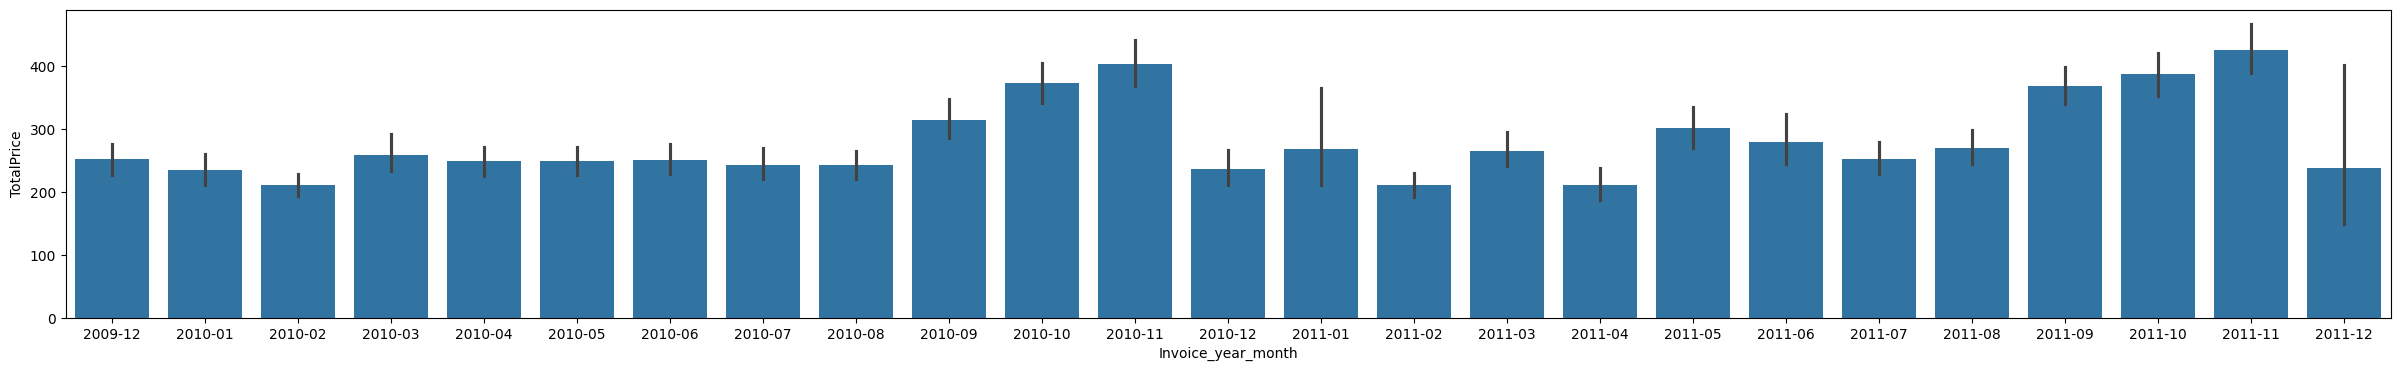

In [381]:
df_new['Invoice_year_month'] = df_new['InvoiceDate'].dt.strftime('%Y-%m')

sales_per_month = df_new.groupby(['Invoice_year_month', 'Description'])['TotalPrice'].sum().reset_index()

plt.figure(figsize=(30,4))
sns.barplot(data=sales_per_month, x='Invoice_year_month', y='TotalPrice')

Too many bar, so we can't see the pattern clearly to analyze the data, we will use the last year data to be analyze

In [382]:
df_2011 = df_new[(df_new['InvoiceDate'] >= '2011-01-01') & (df_new['InvoiceDate'] <= '2011-12-09')]
df_2011.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366449 entries, 567942 to 1065737
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Invoice             366449 non-null  object        
 1   StockCode           366449 non-null  object        
 2   Description         366449 non-null  object        
 3   Quantity            366449 non-null  int64         
 4   InvoiceDate         366449 non-null  datetime64[ns]
 5   Price               366449 non-null  float64       
 6   Customer ID         366449 non-null  int32         
 7   Country             366449 non-null  object        
 8   TotalPrice          366449 non-null  float64       
 9   Invoice_year_month  366449 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(5)
memory usage: 29.4+ MB


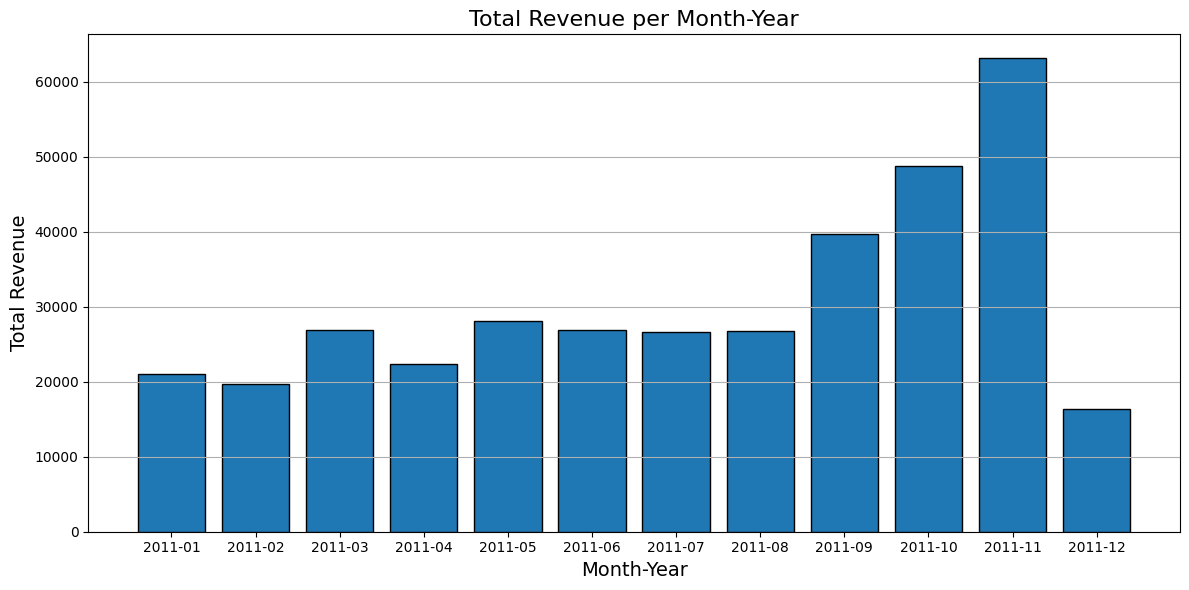

In [383]:
df_2011['Invoice_year_month'] = df_2011['InvoiceDate'].dt.strftime('%Y-%m')

sales_per_month = df_2011.groupby('Invoice_year_month')['TotalPrice'].count().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(sales_per_month['Invoice_year_month'], sales_per_month['TotalPrice'], edgecolor='black')  # Bar plot

plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Total Revenue', fontsize=14)
plt.title('Total Revenue per Month-Year', fontsize=16)

plt.grid(axis='y') 

plt.tight_layout()

plt.show()

**Insight**

1. November become the month with the most orders
2. there is significant differences orders between early 2011 and the end of 2011

#### Top Country 10 to Orders

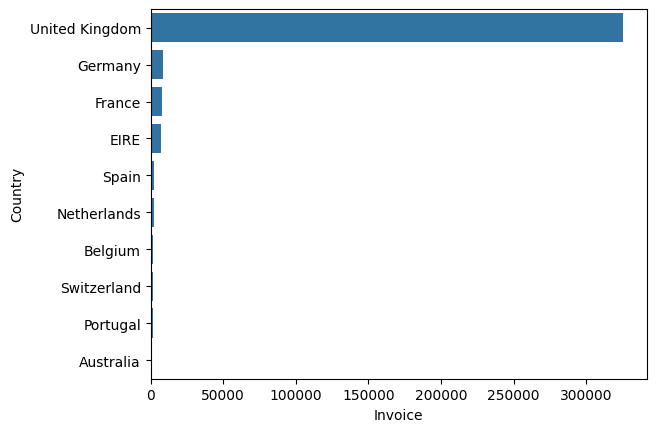

In [384]:
top_country = df_2011.groupby('Country')['Invoice'].count().reset_index().sort_values('Invoice', ascending = False).head(10)
sns.barplot(x = top_country['Invoice'], y = top_country['Country'])
plt.xticks(rotation = 'horizontal')
plt.show()

As country based where the company is, no wonder United Kingdom become the top country with the most Orders

#### Top 10 Product to Orders

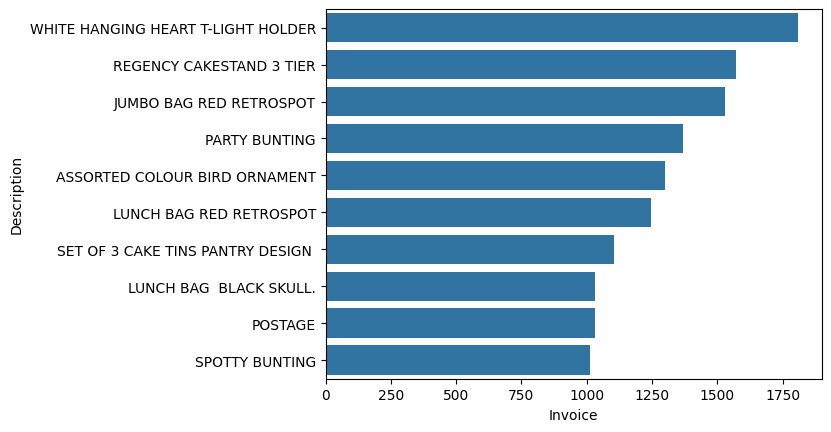

In [385]:
top_product = df_2011.groupby('Description')['Invoice'].count().reset_index().sort_values('Invoice', ascending = False).head(10)
sns.barplot(x = top_product['Invoice'], y = top_product['Description'])
plt.xticks(rotation = 'horizontal')
plt.show()

In [386]:
top_product

,Description,Invoice
3608,WHITE HANGING HEART T-LIGHT HOLDER,1809
2692,REGENCY CAKESTAND 3 TIER,1573
1708,JUMBO BAG RED RETROSPOT,1530
2284,PARTY BUNTING,1367
214,ASSORTED COLOUR BIRD ORNAMENT,1301
1886,LUNCH BAG RED RETROSPOT,1245
2924,SET OF 3 CAKE TINS PANTRY DESIGN,1104
1878,LUNCH BAG BLACK SKULL.,1031
2542,POSTAGE,1030
3242,SPOTTY BUNTING,1012


In [387]:
most_sold = df_2011.groupby(['StockCode', 'Description'])['TotalPrice'].sum().reset_index().sort_values('TotalPrice', ascending = False).head(10)
most_sold

,StockCode,Description,TotalPrice
1289,22423,REGENCY CAKESTAND 3 TIER,124555.75
3381,85123A,WHITE HANGING HEART T-LIGHT HOLDER,90790.05
3367,85099B,JUMBO BAG RED RETROSPOT,81400.54
2053,23166,MEDIUM CERAMIC TOP STORAGE JAR,81366.81
3802,POST,POSTAGE,73214.96
2736,47566,PARTY BUNTING,67991.73
3800,M,Manual,53191.76
3206,84879,ASSORTED COLOUR BIRD ORNAMENT,52733.40
1959,23084,RABBIT NIGHT LIGHT,51098.76
2895,79321,CHILLI LIGHTS,40054.27


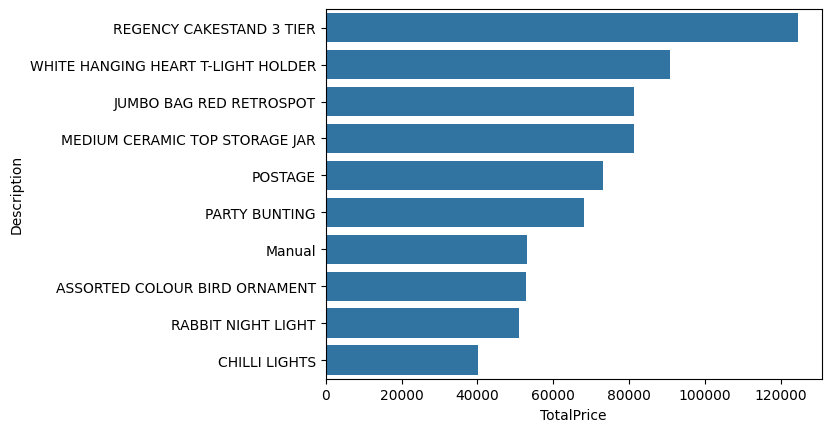

In [388]:
most_sold = df_2011.groupby(['Description'])['TotalPrice'].sum().reset_index().sort_values('TotalPrice', ascending = False).head(10)
sns.barplot(x = most_sold['TotalPrice'], y = most_sold['Description'])
plt.xticks(rotation = 'horizontal')
plt.show()

**Insight**

1. Eventhough `WHITE HANGING HEART T-LIGHT HOLDER` become the most product ordered by the costumer, but in total income `Regency Cakestand 3 Tier` is the top product

#### Free Item On the Last Year

In [389]:
free = df_2011[df_2011['Price'] == 0]
free.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Invoice_year_month
572529,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081,United Kingdom,0.0,2011-01
572531,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081,United Kingdom,0.0,2011-01
582135,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107,United Kingdom,0.0,2011-01
612250,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560,United Kingdom,0.0,2011-02
655649,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239,United Kingdom,0.0,2011-03


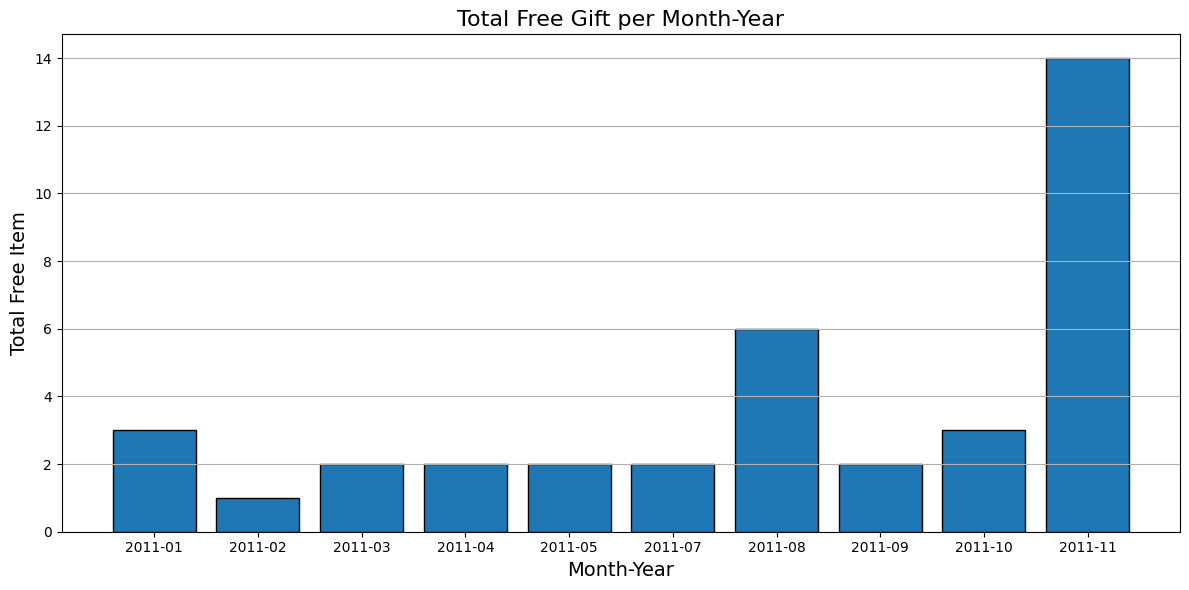

In [390]:
free['Invoice_year_month'] = free['InvoiceDate'].dt.strftime('%Y-%m')

free_per_month = free.groupby('Invoice_year_month')['Invoice'].count().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(free_per_month['Invoice_year_month'], free_per_month['Invoice'], edgecolor='black')  # Bar plot

plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Total Free Item', fontsize=14)
plt.title('Total Free Gift per Month-Year', fontsize=16)

plt.grid(axis='y') 

plt.tight_layout()

plt.show()

The Company consistenly gift free items each month except on December 2011, On average, company gift 2 free items each month, and the november become the month of the year for free item.

# 5. Customer Segmentation

## 5.1 RFM Model for Customer Segmentation

Since our dataset is limited to the sales records, and didn´t include anothers information about our customers, we will use a RFM,*Recency, Frequency and Monetary Value, based model of customer value for finding our customer segments. The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:

  1. R (Recency) : Duration between last transaction date and the data taken date.
  2. F (Frequency) : Total number of transaction
  3. M (Monetary) : Total spend by customer

In [391]:
df_2011.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366449 entries, 567942 to 1065737
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Invoice             366449 non-null  object        
 1   StockCode           366449 non-null  object        
 2   Description         366449 non-null  object        
 3   Quantity            366449 non-null  int64         
 4   InvoiceDate         366449 non-null  datetime64[ns]
 5   Price               366449 non-null  float64       
 6   Customer ID         366449 non-null  int32         
 7   Country             366449 non-null  object        
 8   TotalPrice          366449 non-null  float64       
 9   Invoice_year_month  366449 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(5)
memory usage: 29.4+ MB


### 5.1.1 Recency (R)

Recency is use to know when was the last time a customer made a transaction on our platform

In [392]:
today_date = df_2011['InvoiceDate'].max()+ dt.timedelta(days=2)
today_date

Timestamp('2011-12-10 20:01:00')

In [393]:
recency = df_2011.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days
                                        }).reset_index()
recency = recency.rename(columns={"InvoiceDate": "recency"})
recency.head()

,Customer ID,recency
0,12346,326
1,12347,3
2,12348,76
3,12349,19
4,12350,311


<Axes: xlabel='recency', ylabel='Density'>

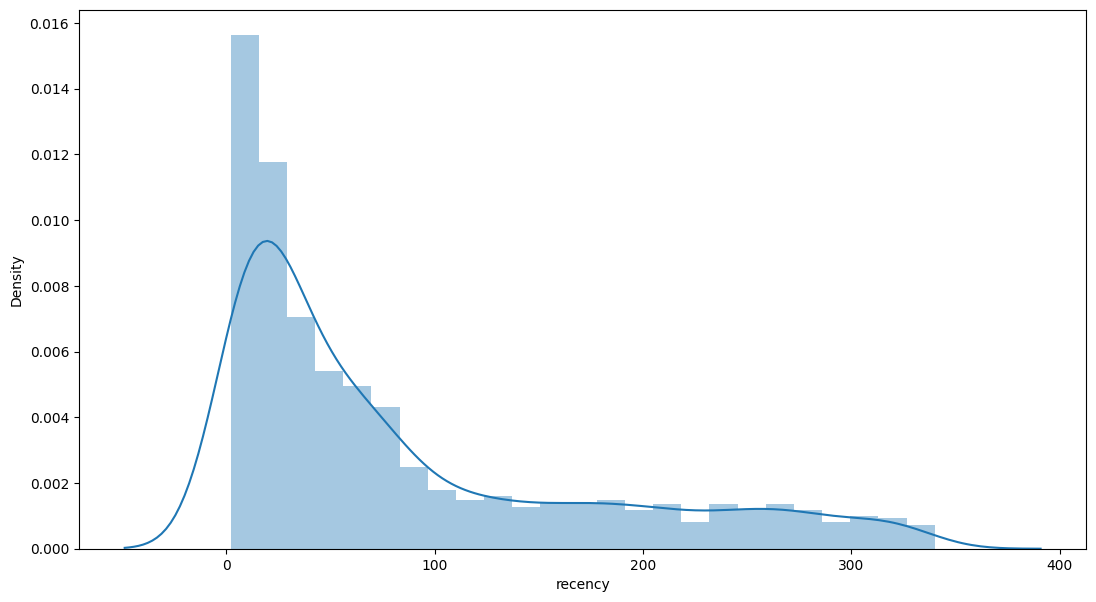

In [394]:
fig, ax = plt.subplots(figsize=(13, 7))
sns.distplot(recency.recency)

From the first graph above we can see that sales recency distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased

### 5.1.2 Frequency

Frequency helps us to find out how often the customer do transaction on our platform

In [395]:
frequency = df_2011.groupby('Customer ID').agg({'Invoice' : ['count']}).reset_index()
frequency.columns = ['Customer ID', 'frequency']
frequency.head()

,Customer ID,frequency
0,12346,1
1,12347,151
2,12348,14
3,12349,73
4,12350,17


<Axes: xlabel='frequency', ylabel='Density'>

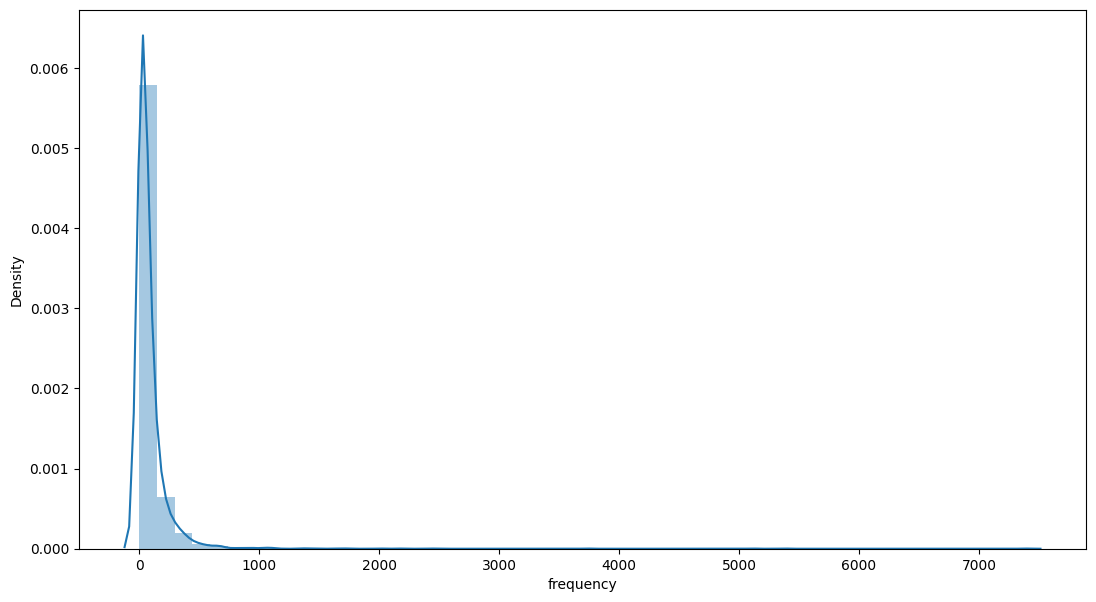

In [396]:
fig, ax = plt.subplots(figsize=(13, 7))
sns.distplot(frequency.frequency)

### 5.1.3 Monetary

Monetary helps us to know the total spend by customer

In [397]:
monetary = df_2011.groupby('Customer ID').agg({'TotalPrice' : ['sum']}).reset_index()
monetary.columns = ['Customer ID', 'monetary']
monetary.head()

,Customer ID,monetary
0,12346,77183.60
1,12347,3598.21
2,12348,904.44
3,12349,1757.55
4,12350,334.40


<Axes: xlabel='monetary', ylabel='Density'>

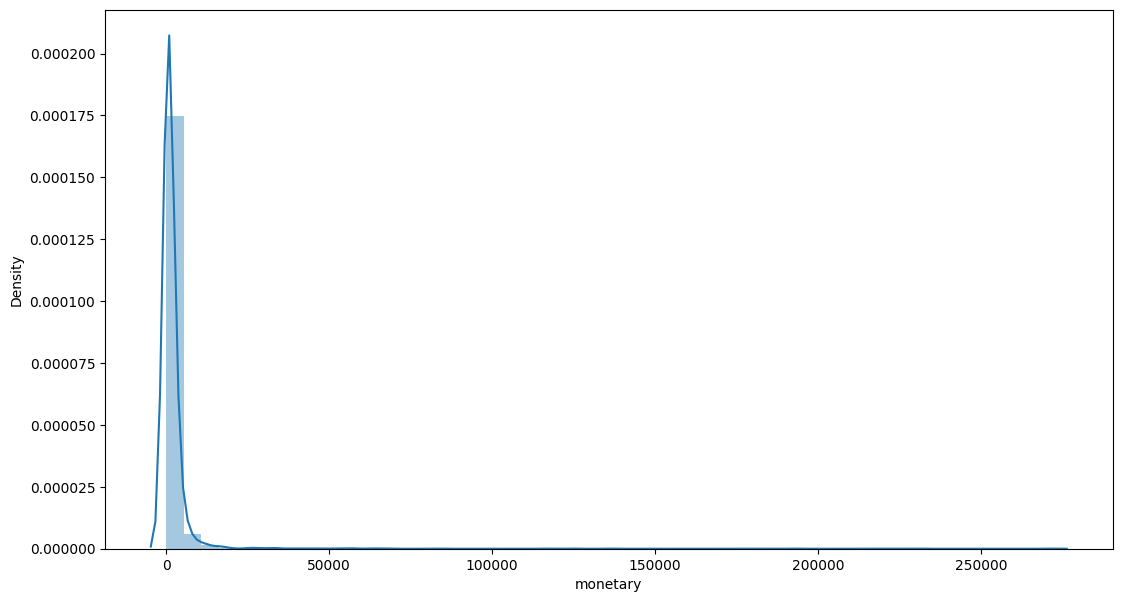

In [398]:
fig, ax = plt.subplots(figsize=(13, 7))
sns.distplot(monetary.monetary)

### 5.1.4 RFM Table

In [399]:
rf_f = recency.merge(frequency, on = 'Customer ID')
rf_f.head()

,Customer ID,recency,frequency
0,12346,326,1
1,12347,3,151
2,12348,76,14
3,12349,19,73
4,12350,311,17


In [400]:
rfm = rf_f.merge(monetary, on = 'Customer ID')
rfm.head()

,Customer ID,recency,frequency,monetary
0,12346,326,1,77183.60
1,12347,3,151,3598.21
2,12348,76,14,904.44
3,12349,19,73,1757.55
4,12350,311,17,334.40


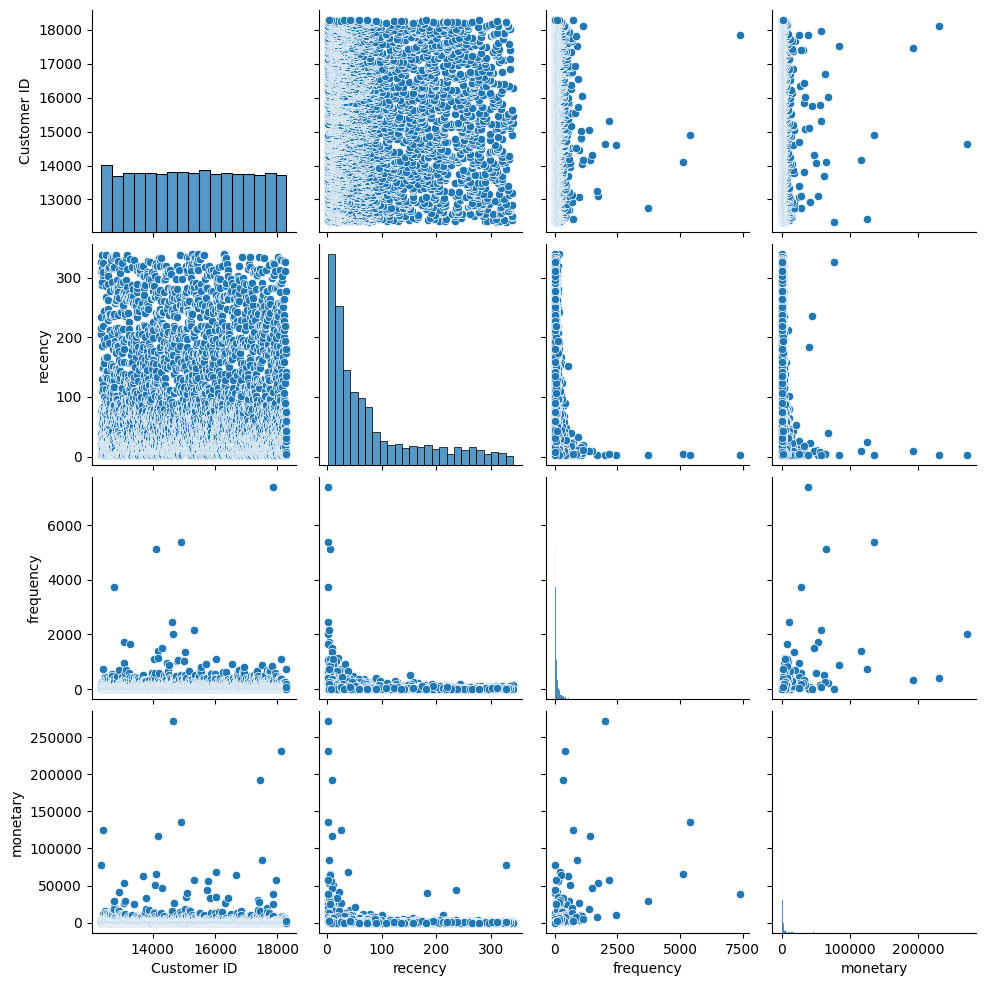

In [401]:
sns.pairplot(rfm, diag_kind="hist")

### 5.1.5 RFM Standarization

In [402]:
features = ['frequency', 'monetary', 'recency']
X_std = StandardScaler().fit_transform(rfm[features])
rfm_std = pd.DataFrame(data = X_std, columns= features)
rfm_std.head()

,frequency,monetary,recency
0,-0.397194,9.098160,2.672711
1,0.296741,0.201973,-0.917788
2,-0.337053,-0.123694,-0.106313
3,-0.064105,-0.020556,-0.739930
4,-0.323174,-0.192609,2.505969


### 5.2 Clustering Using K-Mean Cluster

### 5.2.1 Elbow Method

iterasi ke- 2 dengan nilai inertia :  9157.040600758686
iterasi ke- 3 dengan nilai inertia :  5247.438430645214
iterasi ke- 4 dengan nilai inertia :  3914.937290273607
iterasi ke- 5 dengan nilai inertia :  2915.4283444873254
iterasi ke- 6 dengan nilai inertia :  2307.25538793125
iterasi ke- 7 dengan nilai inertia :  1885.7875831853707
iterasi ke- 8 dengan nilai inertia :  1627.4454629383283
iterasi ke- 9 dengan nilai inertia :  1439.2056637348155
iterasi ke- 10 dengan nilai inertia :  1293.2339072575937


<Axes: >

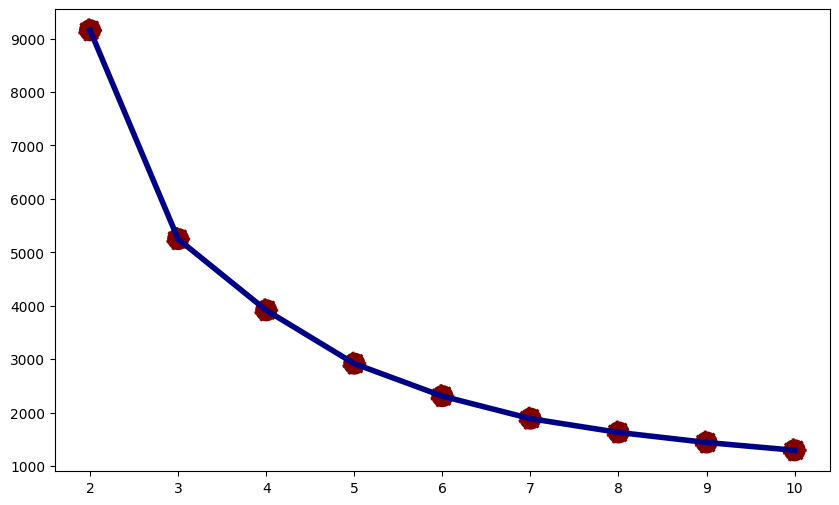

In [403]:
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_std)
    nilai_inertia = kmeans.inertia_
    print('iterasi ke-',i, 'dengan nilai inertia : ',nilai_inertia)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))

sns.lineplot(x=range(2, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 11), y=inertia, s=300, color='#800000',  linestyle='--')

According to the graphic  (Elbow Method), the angle change start occur at point 3, 4, 5 and we will continue to evaluate the options more deeply starting with silhouette score analysis.

### 5.2.2 Silhouette Analysis

In [404]:
arr_silhouette_score_euclidean = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i).fit(X_std)
    preds = kmeans.predict(rfm_std)

    score_euclidean = silhouette_score(rfm_std, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)
    print('For', i, 'The Silhouette Score is :', score_euclidean)

For 2 The Silhouette Score is : 0.9325726790530453
For 3 The Silhouette Score is : 0.602715468188553
For 4 The Silhouette Score is : 0.6006125898167474
For 5 The Silhouette Score is : 0.6091110245727241
For 6 The Silhouette Score is : 0.586093295033784
For 7 The Silhouette Score is : 0.5070905279160558
For 8 The Silhouette Score is : 0.4172375197471442
For 9 The Silhouette Score is : 0.5122205059112658
For 10 The Silhouette Score is : 0.43630812937150804


**Insight**

1. At the first sight we can between 3,4,5, the K = 4 obtain the lowest silhouette score, so we're gonna eliminate it from the option.
2. in the other hand, all other option had a lower score then the big 3.
3. so we will evaluate the K = 3 and K = 5 in the future analysis.

### 5.2.3 Cluster Insight And Analysis

In [405]:
# Cluster 3
kmeans3 = KMeans(n_clusters = 3, random_state = 0)
kmeans3.fit(X_std)

KMeans(n_clusters=3, random_state=0)

In [406]:
# Cluster 5
kmeans5 = KMeans(n_clusters = 5, random_state = 0)
kmeans5.fit(X_std)

KMeans(n_clusters=5, random_state=0)

In [407]:
# Adding cluster to scaled dataset
rfm_std['cluster_5'] = kmeans5.labels_
rfm_std['cluster_3'] = kmeans3.labels_

# Adding cluster to unscaled dataset
rfm['cluster_5'] = kmeans5.labels_
rfm['cluster_3'] = kmeans3.labels_

In [408]:
rfm.head()

,Customer ID,recency,frequency,monetary,cluster_5,cluster_3
0,12346,326,1,77183.60,4,0
1,12347,3,151,3598.21,1,1
2,12348,76,14,904.44,1,1
3,12349,19,73,1757.55,1,1
4,12350,311,17,334.40,0,0


### 5.2.3.1 Cluster Evaluation

#### PCA Evaluation

In [409]:
rfm_std.head()

,frequency,monetary,recency,cluster_5,cluster_3
0,-0.397194,9.098160,2.672711,4,0
1,0.296741,0.201973,-0.917788,1,1
2,-0.337053,-0.123694,-0.106313,1,1
3,-0.064105,-0.020556,-0.739930,1,1
4,-0.323174,-0.192609,2.505969,0,0


In [410]:
# Cluter 3 Evaluation
pca = PCA(n_components=2)

pca.fit(rfm_std)
pcs3 = pca.transform(rfm_std)


df_pca3 = pd.DataFrame(data = pcs3, columns = ['PC 1', 'PC 2'])
df_pca3['cluster_3'] = rfm_std['cluster_3']
df_pca3

,PC 1,PC 2,cluster_3
0,3.843801,6.378465,0
1,0.790255,-0.427829,1
2,-0.086256,-0.348554,1
3,0.415714,-0.586812,1
4,-2.111954,1.727327,0
...,...,...,...
4214,-1.955088,1.467606,0
4215,-1.432824,0.761449,0
4216,0.244945,-0.889009,1
4217,3.542983,-0.039456,1


Text(0.5, 1.0, 'Customer Segmentation Based on RFM Model')

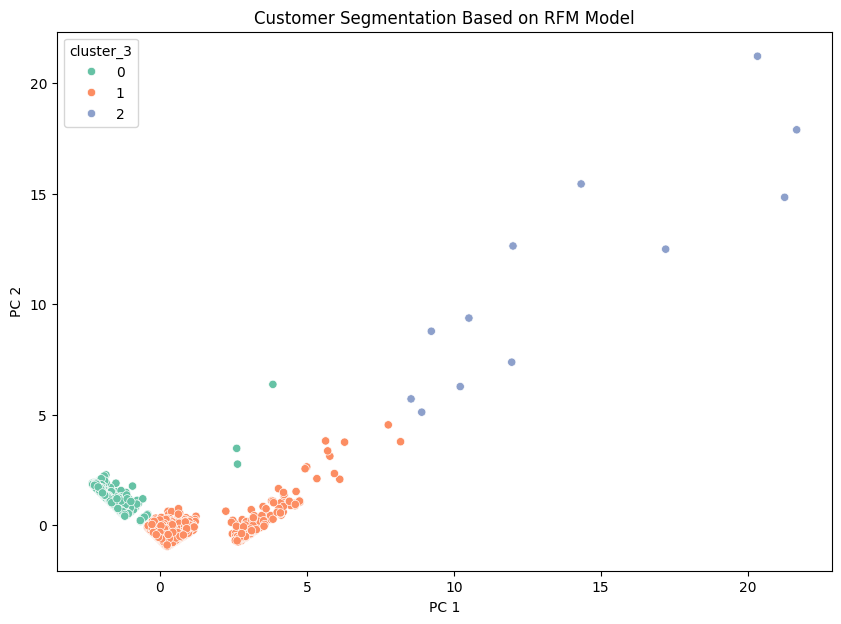

In [411]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=df_pca3, x="PC 1", y="PC 2", hue="cluster_3", palette= "Set2", )
plt.title('Customer Segmentation Based on RFM Model')

In [412]:
# Cluster 5 Evaluation
pcs5 = pca.transform(rfm_std)


df_pca5 = pd.DataFrame(data = pcs5, columns = ['PC 1', 'PC 2'])
df_pca5['cluster_5'] = rfm_std['cluster_5']
df_pca5

,PC 1,PC 2,cluster_5
0,3.843801,6.378465,4
1,0.790255,-0.427829,1
2,-0.086256,-0.348554,1
3,0.415714,-0.586812,1
4,-2.111954,1.727327,0
...,...,...,...
4214,-1.955088,1.467606,0
4215,-1.432824,0.761449,0
4216,0.244945,-0.889009,1
4217,3.542983,-0.039456,4


Text(0.5, 1.0, 'Customer Segmentation Based on RFM Model')

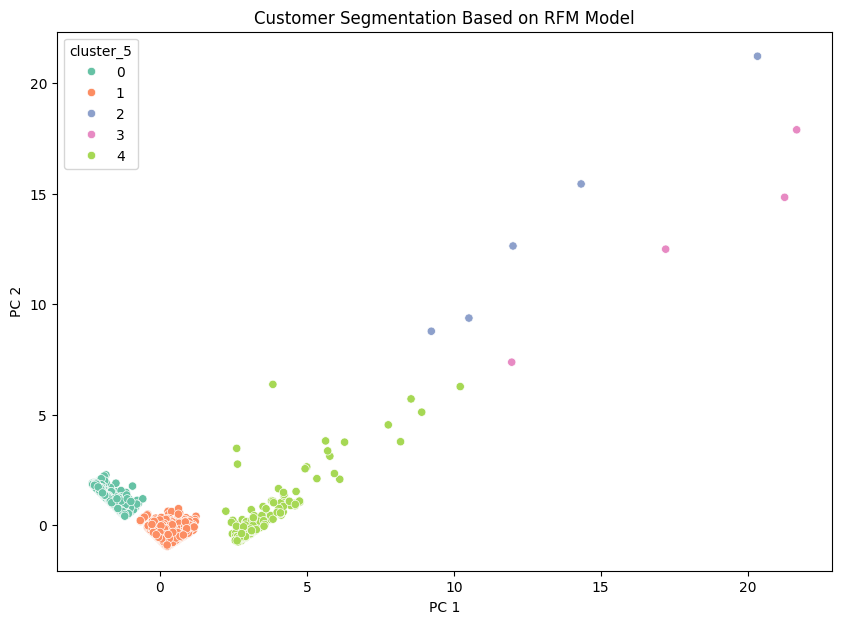

In [413]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=df_pca5, x="PC 1", y="PC 2", hue="cluster_5", palette= "Set2", )
plt.title('Customer Segmentation Based on RFM Model')

#### TSNE Evaluation

In [414]:
from sklearn.manifold import TSNE
Xtsne = TSNE(n_components=2).fit_transform(rfm_std)
dftsne = pd.DataFrame(Xtsne)
dftsne['clusters'] = rfm_std['cluster_5']
dftsne.columns = ['x1','x2','clusters']

Text(0.5, 1.0, 'Customer Segmentation Based on TSNE Model')

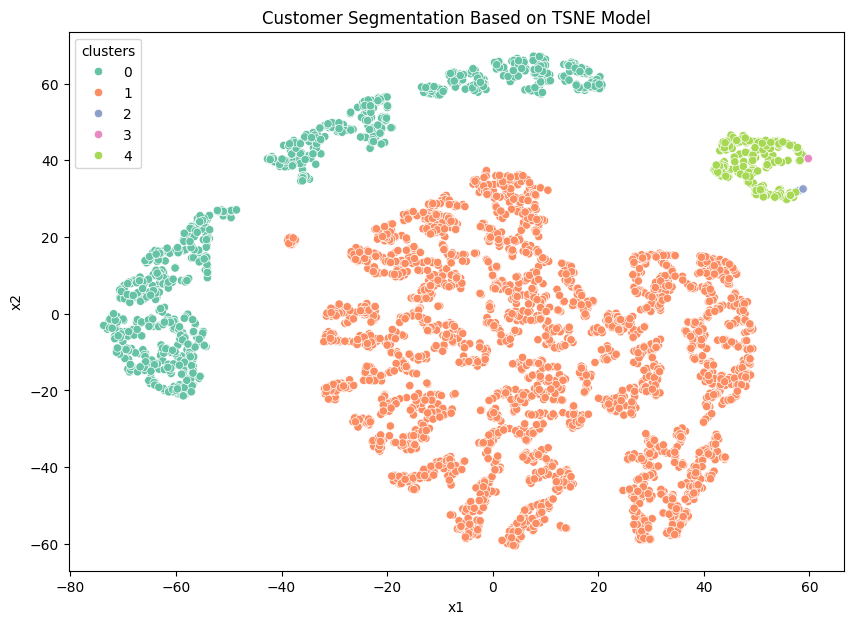

In [415]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=dftsne, x="x1", y="x2", hue="clusters", palette= "Set2", )
plt.title('Customer Segmentation Based on TSNE Model')

### 5.3.4 Cluster Insight

In [416]:
rfm.head()

,Customer ID,recency,frequency,monetary,cluster_5,cluster_3
0,12346,326,1,77183.60,4,0
1,12347,3,151,3598.21,1,1
2,12348,76,14,904.44,1,1
3,12349,19,73,1757.55,1,1
4,12350,311,17,334.40,0,0


In [417]:
rfm.drop('cluster_3', axis = 1, inplace= True)
rfm.head()

,Customer ID,recency,frequency,monetary,cluster_5
0,12346,326,1,77183.60,4
1,12347,3,151,3598.21,1
2,12348,76,14,904.44,1
3,12349,19,73,1757.55,1
4,12350,311,17,334.40,0


In [446]:
centroid_rfm = rfm.groupby('cluster_5')[['recency', 'frequency', 'monetary','Customer ID']].agg({
    'recency': 'mean', 'frequency': 'mean', 'monetary':'mean','Customer ID':'nunique'}).reset_index()
centroid_rfm = centroid_rfm.rename(columns = {'Customer ID':'NumBuyers'})
centroid_rfm

,cluster_5,recency,frequency,monetary,NumBuyers
0,0,227.761811,26.482283,474.910985,1016
1,1,42.285955,70.563826,1302.946976,2969
2,2,9.600000,972.600000,187426.350000,5
3,3,2.750000,5404.500000,66990.955000,4
4,4,17.697778,460.257778,11450.674667,225


In [447]:
cluster_map = {
    0 : 'Hibernating',
    1 : 'Promising',
    2 : 'Champion',
    3 : 'Loyalist Customer',
    4 : 'Potential loyal Customer'
}
centroid_rfm = centroid_rfm.replace({'cluster_5' : cluster_map})
centroid_rfm

,cluster_5,recency,frequency,monetary,NumBuyers
0,Hibernating,227.761811,26.482283,474.910985,1016
1,Promising,42.285955,70.563826,1302.946976,2969
2,Champion,9.600000,972.600000,187426.350000,5
3,Loyalist Customer,2.750000,5404.500000,66990.955000,4
4,Potential loyal Customer,17.697778,460.257778,11450.674667,225


**Insgith from 5 clusters**

1. Cluster 0 is Hibernating : There are 1.016 people in this segments, they do not shop for an average 227 days, they shopped for an average 26 times, they earned an average 474/475 monetary.
2. Cluster 1 is Promising : There are 2969 people in this segments, they do not shop for an average 42 days, the shopped for an average 70 times, they earned an average 1.303 monetary.
3. Cluster 2 the Champion : There are 5 people in this segments, they do not shop for an average 9 days, they shopped for an average 972 times, they earned an average 187.426 monetary.
4. cluster 3 is Loyalist Customer : There are 4 people in this segments, they do not shop for an average 2 days, they shopped for an average 5.404 times, they earned an average 66.991 monetary.
5. Cluster 4 the Potential Loyal Customer : There are 225 people in this segments, they do not shop for an average 17 days, they shopped for an average 460 times, they earned an average 11.450 monetary.

# 6. Cluster Analysis

In [448]:
all_data = pd.merge(df_2011, rfm, on = 'Customer ID', how = 'right')
all_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Invoice_year_month,recency,frequency,monetary,cluster_5
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.60,2011-01,326,1,77183.60,4
1,542237,84625A,PINK NEW BAROQUECANDLESTICK CANDLE,24,2011-01-26 14:30:00,0.85,12347,Iceland,20.40,2011-01,3,151,3598.21,1
2,542237,84625C,BLUE NEW BAROQUE CANDLESTICK CANDLE,24,2011-01-26 14:30:00,0.85,12347,Iceland,20.40,2011-01,3,151,3598.21,1
3,542237,85116,BLACK CANDELABRA T-LIGHT HOLDER,6,2011-01-26 14:30:00,2.10,12347,Iceland,12.60,2011-01,3,151,3598.21,1
4,542237,20719,WOODLAND CHARLOTTE BAG,10,2011-01-26 14:30:00,0.85,12347,Iceland,8.50,2011-01,3,151,3598.21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366444,570715,22419,LIPSTICK PEN RED,12,2011-10-12 10:23:00,0.42,18287,United Kingdom,5.04,2011-10,43,70,1837.28,1
366445,570715,22866,HAND WARMER SCOTTY DOG DESIGN,12,2011-10-12 10:23:00,2.10,18287,United Kingdom,25.20,2011-10,43,70,1837.28,1
366446,573167,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,36,2011-10-28 09:29:00,1.25,18287,United Kingdom,45.00,2011-10,43,70,1837.28,1
366447,573167,21824,PAINTED METAL STAR WITH HOLLY BELLS,48,2011-10-28 09:29:00,0.39,18287,United Kingdom,18.72,2011-10,43,70,1837.28,1


In [449]:
all_data = all_data.replace({'cluster_5' : cluster_map})
all_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Invoice_year_month,recency,frequency,monetary,cluster_5
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.60,2011-01,326,1,77183.60,Potential loyal Customer
1,542237,84625A,PINK NEW BAROQUECANDLESTICK CANDLE,24,2011-01-26 14:30:00,0.85,12347,Iceland,20.40,2011-01,3,151,3598.21,Promising
2,542237,84625C,BLUE NEW BAROQUE CANDLESTICK CANDLE,24,2011-01-26 14:30:00,0.85,12347,Iceland,20.40,2011-01,3,151,3598.21,Promising
3,542237,85116,BLACK CANDELABRA T-LIGHT HOLDER,6,2011-01-26 14:30:00,2.10,12347,Iceland,12.60,2011-01,3,151,3598.21,Promising
4,542237,20719,WOODLAND CHARLOTTE BAG,10,2011-01-26 14:30:00,0.85,12347,Iceland,8.50,2011-01,3,151,3598.21,Promising
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366444,570715,22419,LIPSTICK PEN RED,12,2011-10-12 10:23:00,0.42,18287,United Kingdom,5.04,2011-10,43,70,1837.28,Promising
366445,570715,22866,HAND WARMER SCOTTY DOG DESIGN,12,2011-10-12 10:23:00,2.10,18287,United Kingdom,25.20,2011-10,43,70,1837.28,Promising
366446,573167,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,36,2011-10-28 09:29:00,1.25,18287,United Kingdom,45.00,2011-10,43,70,1837.28,Promising
366447,573167,21824,PAINTED METAL STAR WITH HOLLY BELLS,48,2011-10-28 09:29:00,0.39,18287,United Kingdom,18.72,2011-10,43,70,1837.28,Promising


### 6.1 Hibernating

In [451]:
hibernating = all_data[all_data['cluster_5'] == 'Hibernating']
hibernating.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Invoice_year_month,recency,frequency,monetary,cluster_5
239,543037,21908,CHOCOLATE THIS WAY METAL SIGN,12,2011-02-02 16:01:00,2.10,12350,Norway,25.2,2011-02,311,17,334.4,Hibernating
240,543037,22412,METAL SIGN NEIGHBOURHOOD WITCH,12,2011-02-02 16:01:00,2.10,12350,Norway,25.2,2011-02,311,17,334.4,Hibernating
241,543037,79066K,RETRO MOD TRAY,10,2011-02-02 16:01:00,0.85,12350,Norway,8.5,2011-02,311,17,334.4,Hibernating
242,543037,79191C,RETRO PLASTIC ELEPHANT TRAY,12,2011-02-02 16:01:00,0.85,12350,Norway,10.2,2011-02,311,17,334.4,Hibernating
243,543037,22348,TEA BAG PLATE RED RETROSPOT,24,2011-02-02 16:01:00,0.85,12350,Norway,20.4,2011-02,311,17,334.4,Hibernating


<Axes: xlabel='Invoice_year_month', ylabel='TotalPrice'>

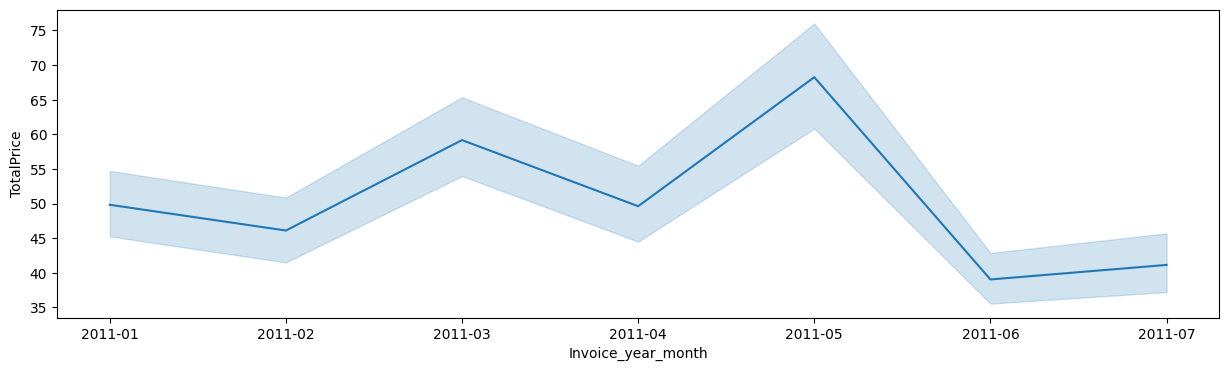

In [452]:
hibernating['Invoice_year_month'] = hibernating['InvoiceDate'].dt.strftime('%Y-%m')

sales_per_month_hibernating = hibernating.groupby(['Invoice_year_month', 'Description'])['TotalPrice'].sum().reset_index()

plt.figure(figsize=(15,4))
sns.lineplot(data=sales_per_month_hibernating, x='Invoice_year_month', y='TotalPrice')

From the graph, we can see that spending in the `Hibernating` cluster appears quite fluctuating, reaching its peak transactions in May, and the last transaction was made in July.

In [453]:
hibernating_product = hibernating.groupby(['Description']).agg({
    'Quantity' : 'sum', 'TotalPrice' : 'sum', 'Price' : 'mean'
}).reset_index().sort_values('TotalPrice', ascending=False).head(5)
hibernating_product


,Description,Quantity,TotalPrice,Price
1933,REGENCY CAKESTAND 3 TIER,741,8842.95,12.553279
1816,POSTAGE,216,6333.84,37.633412
1635,PARTY BUNTING,1295,6110.15,4.899057
2563,WHITE HANGING HEART T-LIGHT HOLDER,2058,5736.70,2.912694
2198,SET/4 WHITE RETRO STORAGE CUBES,149,5257.55,37.302941


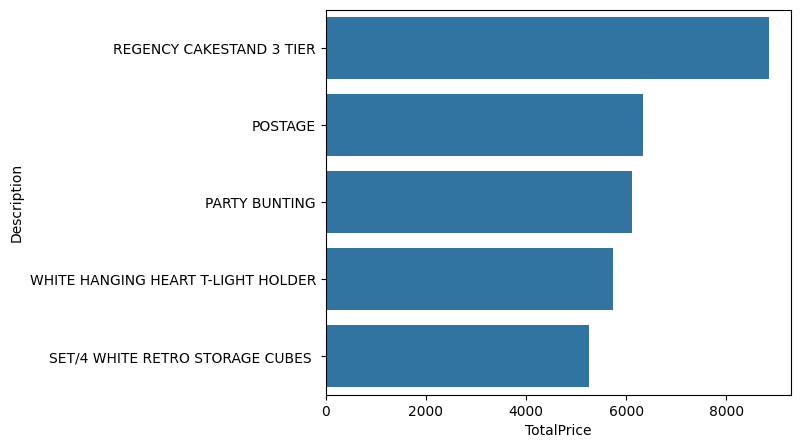

In [454]:
plt.figure(figsize= (6, 5))
sns.barplot(x = hibernating_product['TotalPrice'], y = hibernating_product['Description'])
plt.xticks(rotation = 'horizontal')
plt.show()

From the list of items purchased by the `Hibernating` cluster, they are buying mid-range products. It seems that they do not mind the price of the items, as they are also buying these products in moderate quantities.

Action for this Cluster :
1. Send regular newsletters or updates highlighting new mid-range products, special offers, and updates about the platform.
2. Reach out to these customers for feedback on why they stopped transacting and address any issues or concerns they may have.
3. Ensure the platform is user-friendly and efficient, as a better shopping experience might motivate them to return.

### 6.2 Promising

In [455]:
promising = all_data[all_data['cluster_5'] == 'Promising']
promising.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Invoice_year_month,recency,frequency,monetary,cluster_5
1,542237,84625A,PINK NEW BAROQUECANDLESTICK CANDLE,24,2011-01-26 14:30:00,0.85,12347,Iceland,20.4,2011-01,3,151,3598.21,Promising
2,542237,84625C,BLUE NEW BAROQUE CANDLESTICK CANDLE,24,2011-01-26 14:30:00,0.85,12347,Iceland,20.4,2011-01,3,151,3598.21,Promising
3,542237,85116,BLACK CANDELABRA T-LIGHT HOLDER,6,2011-01-26 14:30:00,2.10,12347,Iceland,12.6,2011-01,3,151,3598.21,Promising
4,542237,20719,WOODLAND CHARLOTTE BAG,10,2011-01-26 14:30:00,0.85,12347,Iceland,8.5,2011-01,3,151,3598.21,Promising
5,542237,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-01-26 14:30:00,4.25,12347,Iceland,17.0,2011-01,3,151,3598.21,Promising


<Axes: xlabel='Invoice_year_month', ylabel='TotalPrice'>

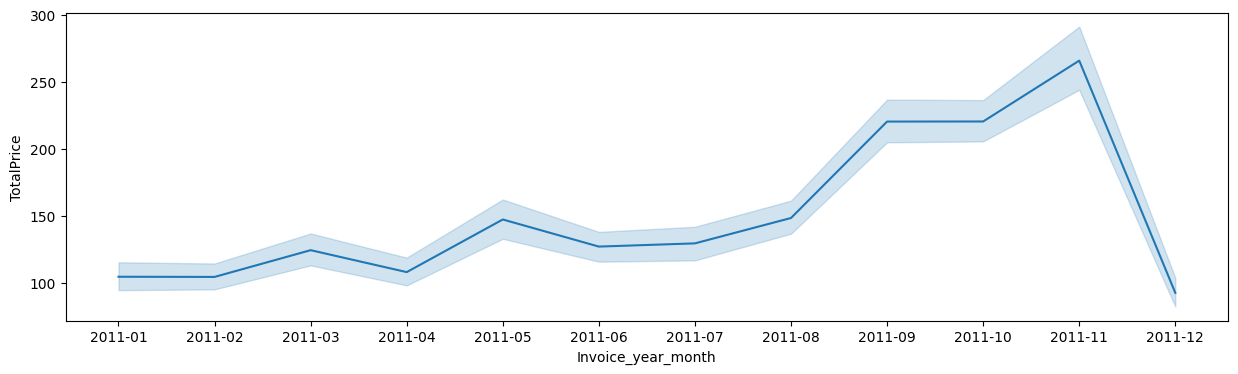

In [456]:
promising['Invoice_year_month'] = promising['InvoiceDate'].dt.strftime('%Y-%m')

sales_per_month_promising = promising.groupby(['Invoice_year_month', 'Description'])['TotalPrice'].sum().reset_index()

plt.figure(figsize=(15,4))
sns.lineplot(data=sales_per_month_promising, x='Invoice_year_month', y='TotalPrice')

From the graph above, we can see that the transaction activity of the promising cluster has been increasing month by month, reaching its peak in November.

In [481]:
promising_product = promising.groupby(['Description']).agg({
    'Quantity' : 'sum', 'TotalPrice' : 'sum', 'Price' : 'mean'
}).reset_index().sort_values('TotalPrice', ascending=False).head(5)
promising_product


,Description,Quantity,TotalPrice,Price
2543,REGENCY CAKESTAND 3 TIER,4288,50474.50,12.520709
2402,POSTAGE,1978,43581.37,22.564839
1614,JUMBO BAG RED RETROSPOT,17925,34351.54,2.036822
3432,WHITE HANGING HEART T-LIGHT HOLDER,12252,33761.40,2.897674
2166,PARTY BUNTING,7163,32830.65,4.885646


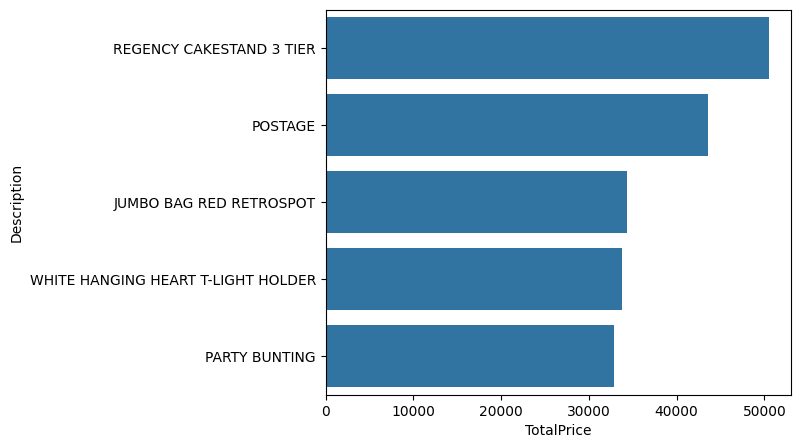

In [458]:
plt.figure(figsize= (6, 5))
sns.barplot(x = promising_product['TotalPrice'], y = promising_product['Description'])
plt.xticks(rotation = 'horizontal')
plt.show()

From the top list based on the income generated by the `Promising` cluster, they tend to buy more cheap products, and they make quite a lot of purchases for cheap products, contributing significantly to the company's income.

Action For this cluster :
1. Plan seasonal promotions around key shopping times, such as November, to capitalize on peak transaction periods.
2. Offer discounts on bulk purchases to incentivize customers to buy in larger quantities, leveraging their tendency to purchase many items.
3. Organize flash sale featuring products they buy most, use limited-time offers to create a sense of urgency, and encourage to quick purchases.

### 6.3 Champion

In [459]:
champion = all_data[all_data['cluster_5'] == 'Champion']
champion.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Invoice_year_month,recency,frequency,monetary,cluster_5
3571,540267,22078,RIBBON REEL LACE DESIGN,120,2011-01-06 11:12:00,1.85,12415,Australia,222.0,2011-01,25,716,124914.53,Champion
3572,540267,22079,RIBBON REEL HEARTS DESIGN,120,2011-01-06 11:12:00,1.45,12415,Australia,174.0,2011-01,25,716,124914.53,Champion
3573,540267,22080,RIBBON REEL POLKADOTS,120,2011-01-06 11:12:00,1.45,12415,Australia,174.0,2011-01,25,716,124914.53,Champion
3574,540267,22077,6 RIBBONS RUSTIC CHARM,144,2011-01-06 11:12:00,1.45,12415,Australia,208.8,2011-01,25,716,124914.53,Champion
3575,540267,22505,MEMO BOARD COTTAGE DESIGN,24,2011-01-06 11:12:00,4.25,12415,Australia,102.0,2011-01,25,716,124914.53,Champion


<Axes: xlabel='Invoice_year_month', ylabel='TotalPrice'>

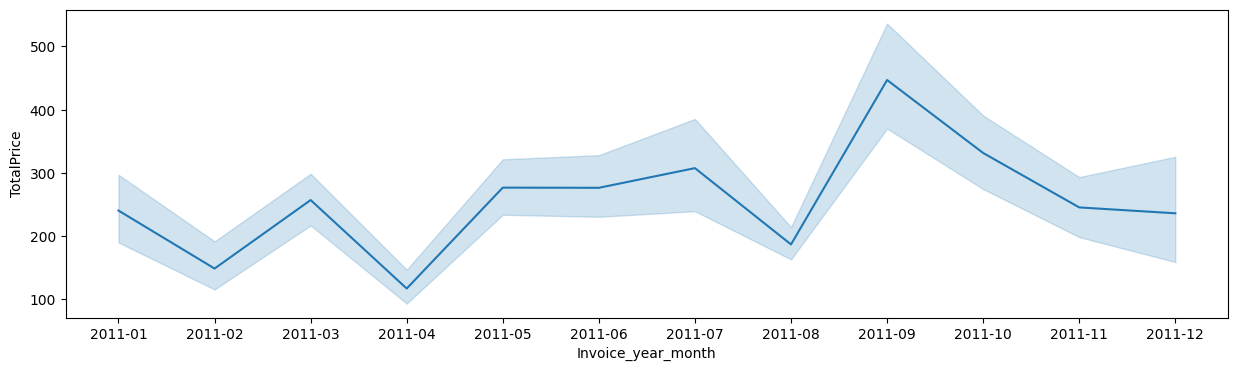

In [460]:
champion['Invoice_year_month'] = champion['InvoiceDate'].dt.strftime('%Y-%m')

sales_per_month_champion = champion.groupby(['Invoice_year_month', 'Description'])['TotalPrice'].sum().reset_index()

plt.figure(figsize=(15,4))
sns.lineplot(data=sales_per_month_champion, x='Invoice_year_month', y='TotalPrice')

From the graph above, it shows fluctuating transaction activity for the `Champion` cluster in the early part of the year and at the end of the year, with peak spending occurring in September.

In [479]:
champion_product = champion.groupby(['Description']).agg({
    'Quantity' : 'sum', 'TotalPrice' : 'sum', 'Price' : 'mean'
}).reset_index().sort_values('TotalPrice', ascending=False).head(5)
champion_product

,Description,Quantity,TotalPrice,Price
1289,WHITE HANGING HEART T-LIGHT HOLDER,4784,14974.34,2.928333
510,HEART OF WICKER LARGE,4144,12719.06,2.841667
1107,SET OF TEA COFFEE SUGAR TINS PANTRY,2651,12644.83,4.360000
886,RABBIT NIGHT LIGHT,6337,12317.92,1.948182
1299,WOOD BLACK BOARD ANT WHITE FINISH,2149,10303.32,4.798125


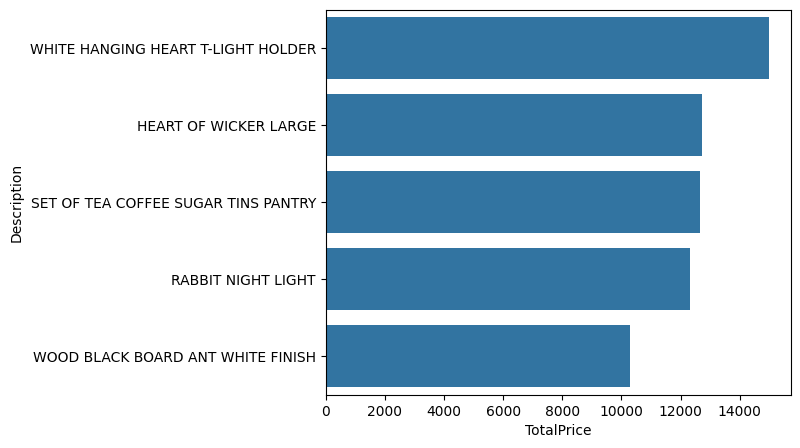

In [463]:
plt.figure(figsize= (6, 5))
sns.barplot(x = champion_product['TotalPrice'], y = champion_product['Description'])
plt.xticks(rotation = 'horizontal')
plt.show()

From the top list of items purchased by the `champion` cluster, this cluster consistently buys cheap products but in promising quantities, providing significant profit to the company.

Action for this cluster :
1. Consider offering a subscription model for the cheap products they frequently buy. This not only provides recurring revenue but also ensures that this cluster remains regularly engaged with your platform.
2. Provide exclusive access to new products or special offers only for this cluster. This will make them feel valued and increase loyalty.
3. Ensure a smooth and efficient shopping experience by improving website navigation, checkout process, and customer service. Make the platform user-friendly to encourage repeat purchases.
4. Provide premium, responsive customer service exclusively for cluster champion. Ensure any issues or inquiries they have are handled promptly and efficiently.

### 6.4 Loyalist Customer

In [464]:
loyalist = all_data[all_data['cluster_5'] == 'Loyalist Customer']
loyalist.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Invoice_year_month,recency,frequency,monetary,cluster_5
27135,540251,84968E,SET OF 16 VINTAGE BLACK CUTLERY,1,2011-01-05 16:06:00,12.75,12748,United Kingdom,12.75,2011-01,2,3737,28774.08,Loyalist Customer
27136,540257,22222,CAKE PLATE LOVEBIRD WHITE,1,2011-01-05 17:33:00,4.95,12748,United Kingdom,4.95,2011-01,2,3737,28774.08,Loyalist Customer
27137,540257,22189,CREAM HEART CARD HOLDER,4,2011-01-05 17:33:00,3.95,12748,United Kingdom,15.80,2011-01,2,3737,28774.08,Loyalist Customer
27138,540257,47590A,BLUE HAPPY BIRTHDAY BUNTING,1,2011-01-05 17:33:00,5.45,12748,United Kingdom,5.45,2011-01,2,3737,28774.08,Loyalist Customer
27139,540257,47566B,TEA TIME PARTY BUNTING,2,2011-01-05 17:33:00,4.65,12748,United Kingdom,9.30,2011-01,2,3737,28774.08,Loyalist Customer


<Axes: xlabel='Invoice_year_month', ylabel='TotalPrice'>

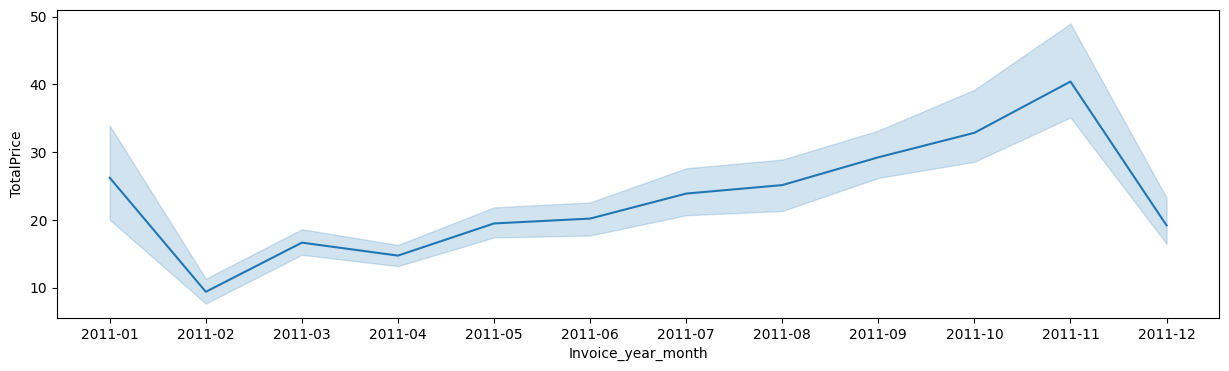

In [465]:
loyalist['Invoice_year_month'] = loyalist['InvoiceDate'].dt.strftime('%Y-%m')

sales_per_month_loyalist = loyalist.groupby(['Invoice_year_month', 'Description'])['TotalPrice'].sum().reset_index()

plt.figure(figsize=(15,4))
sns.lineplot(data=sales_per_month_loyalist, x='Invoice_year_month', y='TotalPrice')

The `Loyalist Customer` Cluster, like promising cluster, this cluster also experienced an increase in transactions from month to month, reaching its peak in November.

In [477]:
loyalist_product = loyalist.groupby(['Description']).agg({
    'Quantity' : 'sum', 'TotalPrice' : 'sum', 'Price' : 'mean'
}).reset_index().sort_values('TotalPrice', ascending=False).head(5)
loyalist_product

,Description,Quantity,TotalPrice,Price
708,DOTCOM POSTAGE,16,11906.36,744.147500
1876,REGENCY CAKESTAND 3 TIER,333,4140.90,14.360294
418,CARRIAGE,79,3925.00,49.683544
488,CHILLI LIGHTS,495,2553.30,6.292778
1570,PAPER CHAIN KIT 50'S CHRISTMAS,704,2346.68,3.849048


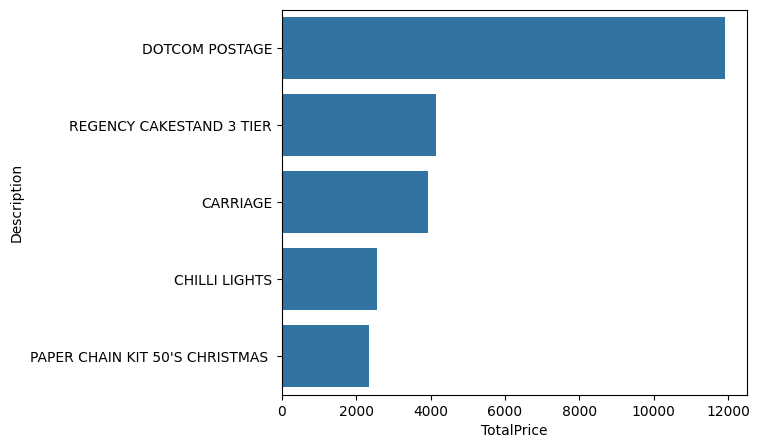

In [475]:
plt.figure(figsize= (6, 5))
sns.barplot(x = loyalist_product['TotalPrice'], y = loyalist_product['Description'])
plt.xticks(rotation = 'horizontal')
plt.show()

Based on the list of items purchased by the loyalist cluster, this cluster does not specialize in specific items. The even distribution of income from each type of product is a unique attraction of the loyalist cluster. Although the quantity of purchases is relatively small, this cluster generates significant income because their spending on luxury, medium, and small items is evenly spread.

Action for this Cluster :
1. Provide incentives for loyalist cluster members to refer friends or family to our platform. A referral program can help expand our customer base.
2. Enhance the loyalist cluster's experience by offering VIP or premium membership programs. This could include benefits like free shipping, priority customer service, or access to exclusive events.

### 6.5 Potential Loyal Customer

In [468]:
potential = all_data[all_data['cluster_5'] == 'Potential loyal Customer']
potential

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Invoice_year_month,recency,frequency,monetary,cluster_5
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.60,2011-01,326,1,77183.60,Potential loyal Customer
4824,545226,21578,WOODLAND DESIGN COTTON TOTE BAG,6,2011-03-01 09:33:00,2.25,12428,Finland,13.50,2011-03,26,294,7956.46,Potential loyal Customer
4825,545226,21002,ROSE DU SUD DRAWSTRING BAG,3,2011-03-01 09:33:00,4.25,12428,Finland,12.75,2011-03,26,294,7956.46,Potential loyal Customer
4826,545226,47599B,BLUE PARTY BAGS,12,2011-03-01 09:33:00,2.10,12428,Finland,25.20,2011-03,26,294,7956.46,Potential loyal Customer
4827,545226,22279,POCKET BAG BLUE PAISLEY RED SPOT,12,2011-03-01 09:33:00,1.25,12428,Finland,15.00,2011-03,26,294,7956.46,Potential loyal Customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366374,580872,22385,JUMBO BAG SPACEBOY DESIGN,3,2011-12-06 12:02:00,2.08,18283,United Kingdom,6.24,2011-12,4,721,2045.53,Potential loyal Customer
366375,580872,23202,JUMBO BAG VINTAGE LEAF,3,2011-12-06 12:02:00,2.08,18283,United Kingdom,6.24,2011-12,4,721,2045.53,Potential loyal Customer
366376,580872,85099F,JUMBO BAG STRAWBERRY,3,2011-12-06 12:02:00,2.08,18283,United Kingdom,6.24,2011-12,4,721,2045.53,Potential loyal Customer
366377,580872,23343,JUMBO BAG VINTAGE CHRISTMAS,10,2011-12-06 12:02:00,2.08,18283,United Kingdom,20.80,2011-12,4,721,2045.53,Potential loyal Customer


<Axes: xlabel='Invoice_year_month', ylabel='TotalPrice'>

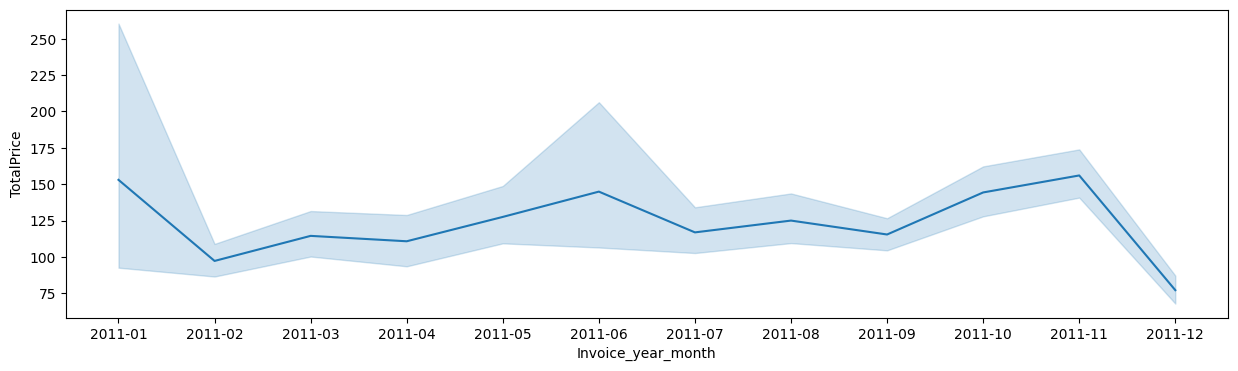

In [482]:
potential['Invoice_year_month'] = potential['InvoiceDate'].dt.strftime('%Y-%m')

sales_per_month_potential = potential.groupby(['Invoice_year_month', 'Description'])['TotalPrice'].sum().reset_index()

plt.figure(figsize=(15,4))
sns.lineplot(data=sales_per_month_potential, x='Invoice_year_month', y='TotalPrice')

in Potential loyal graph we can see that the transaction is quite stable until the end of the year

In [470]:
potential_product = potential.groupby(['Description']).agg({
    'Quantity' : 'sum', 'TotalPrice' : 'sum', 'Price' : 'mean'
}).reset_index().sort_values('TotalPrice', ascending=False).head(5)
potential_product

,Description,Quantity,TotalPrice,Price
1701,MEDIUM CERAMIC TOP STORAGE JAR,75150,78211.23,1.210000
2357,REGENCY CAKESTAND 3 TIER,4701,52897.95,12.178934
1498,JUMBO BAG RED RETROSPOT,22452,40513.06,1.990052
2051,PICNIC BASKET WICKER 60 PIECES,61,39619.50,649.500000
3193,WHITE HANGING HEART T-LIGHT HOLDER,13156,33988.30,2.841700


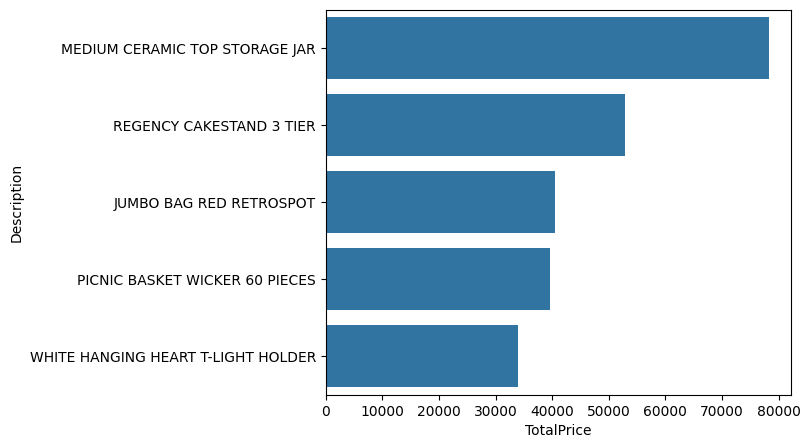

In [472]:
plt.figure(figsize= (6, 5))
sns.barplot(x = potential_product['TotalPrice'], y = potential_product['Description'])
plt.xticks(rotation = 'horizontal')
plt.show()

Cluster potential loyal, like the promising cluster, tends to purchase inexpensive items, but they also show interest in luxury goods. Moreover, their high transaction quantities indicate significant potential for generating income for the company.

action for this cluster :
1. Implement a tiered reward program based on purchase value. Offer additional discounts or exclusive rewards for specific purchases that include luxury items or large quantities.
2. Utilize their shopping behavior data to create a more personalized shopping experience. Send highly relevant product recommendations based on their purchase history, including combinations of inexpensive and luxury products that may appeal to them.